# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [0.7273459156073062, -0.7137895625029701, -1.3112158987551843, 3.195064335503728, 0.6578668590997088, 1.8201670957594605, 2.5774094189910475, 1.2959606640141557, -2.615684720848553, -1.7192495259048919, 0.38510954102334116, 0.7049475219687015, 1.4527158089056038, 1.5438517444010695, 0.8504145036053463, 0.9997932200168839, -0.14767140951984356, 0.6046583528834097, -0.38477500804604936, -1.506202996455002],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
funnel_target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)
funnel_target.d = d
funnel_spl = MCHMC(0.0, 0.5; init_eps=0.3, varE_wanted=1.0, sigma=ones(d));

In [6]:
funnel_samples_mchmc = Sample(funnel_spl, funnel_target, 100000;
                        dialog=true);

[ Info: Tuning eps ⏳


eps: 0.3 --> VarE: 0.0107016741419543
eps: 0.806804029519567 --> VarE: 17.142604952433548
eps: 1.7299635754670148e-7 --> VarE: 4.868088815539872e-20
eps: 4.27565698670104e-7 --> VarE: 3.0786286411800507e-19
eps: 1.0111220503056435e-6 --> VarE: 2.1308654104408e-18
eps: 2.2928404226447367e-6 --> VarE: 2.2516880869314405e-17
eps: 4.995773181741539e-6 --> VarE: 3.726610674127698e-16
eps: 1.0479389380152319e-5 --> VarE: 6.8211565486084435e-15
eps: 2.1202063284048173e-5 --> VarE: 1.15395930743471e-13
eps: 4.144712621012385e-5 --> VarE: 1.72878863941638e-12
eps: 7.841746726730608e-5 --> VarE: 2.2293423856029286e-11
eps: 0.00014382213449771396 --> VarE: 2.2389067181601734e-10
eps: 0.0002560895452030503 --> VarE: 1.2195429912010083e-9
eps: 0.00044334081338079454 --> VarE: 3.5381824176644732e-9
eps: 0.0007472386257779016 --> VarE: 2.6510637659759417e-8
eps: 0.0012277885093682462 --> VarE: 6.07768311752634e-8
eps: 0.0019691089194807236 --> VarE: 1.5840160930054836e-7
eps: 0.0030861057105345015 --

[ Info: Found eps: 0.3398045830811724 ✅


100001-element Vector{Any}:
 [-6.6290275145641075, 0.03228595897538438, 0.02946365134979312, -0.010070397405804283, 0.026557117069168266, -0.07237668377917886, 0.060564520822589306, 0.027374748708765984, 0.0063132010799434755, 0.013558125925774758  …  0.06324504150934937, -0.005720395122866064, 0.020979773918188546, 0.016928648291324264, 0.012337579907503058, -0.00015655519370963856, -0.046582666073974544, -0.020231111105826868, 0.0, -5.402081815854395]
 [-6.597406861564075, 0.019877212005525145, -0.0390534442906388, -0.0025843005618469, 0.017503839452225264, 0.0656842548455098, -0.0343736954417898, -0.018384081595547417, -0.026547746474694007, 0.06170309777400056  …  -0.000589747850527983, -0.009538876564825185, -0.02167046181399524, -0.08784533361342703, -0.12988074164280572, 0.11254832890134762, 0.04185862960216394, -0.021244166167508464, 4.865430552559433, -19.654564505475513]
 [-6.546339050782577, 0.014379177378649603, -0.012203907127689016, -0.019546237368458983, 0.00735013661203

In [7]:
theta_mchmc = [sample[1] for sample in funnel_samples_mchmc]
x10_mchmc = [sample[10+1] for sample in funnel_samples_mchmc];

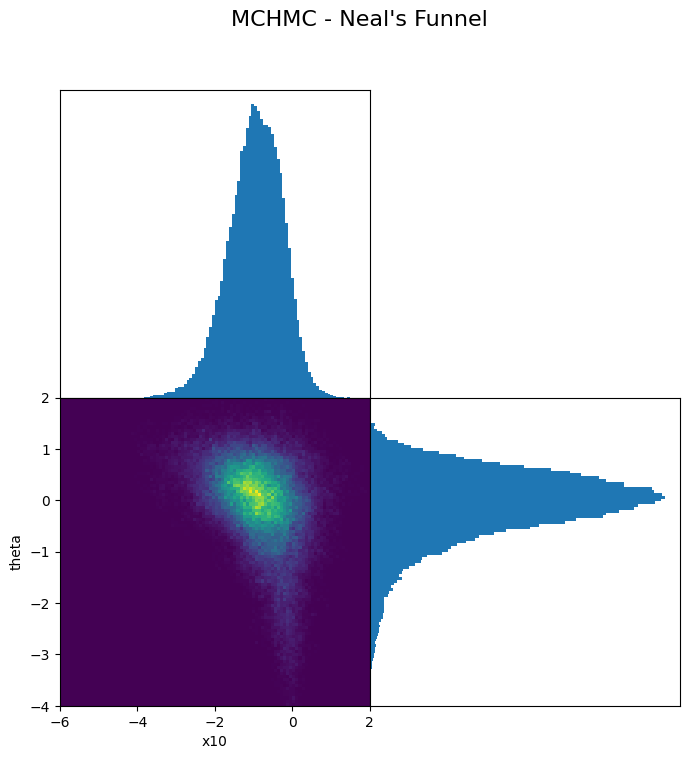

In [14]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## NUTS

In [9]:
funnel_samples_hmc = sample(funnel_model, NUTS(10, 0.65), 100000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (100000×33×1 Array{Float64, 3}):

Iterations        = 11:1:100010
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 22.74 seconds
Compute duration  = 22.74 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse           ess      rhat  ⋯
      Symbol   Float64   Float64    Float64   Float64       Float64   Float64  ⋯

           θ   -0.0294    0.7705     0.0024    0.0151     1831.8909    1.0012  ⋯
        z[1]    0.3625    0.7135     0.0023    0.0030    88124.5642    1.0000  ⋯
        z[2]   -0.3576    0.7123     0.0023    0.0025   109231.5434    1.0000  ⋯
        z[3]   -

In [10]:
theta_hmc = [funnel_samples_hmc.value.data[i, 1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]]
x10_hmc = [funnel_samples_hmc.value.data[i, 10+1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]];

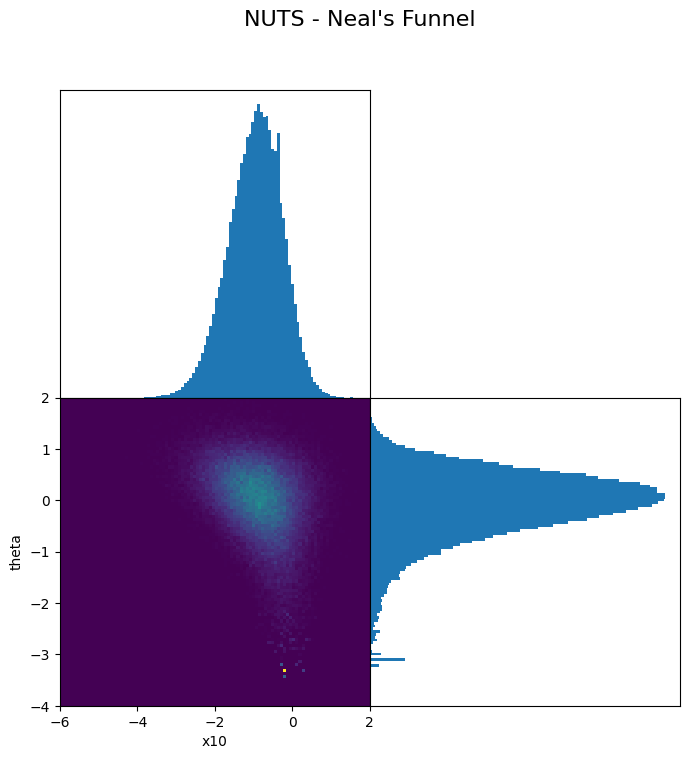

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

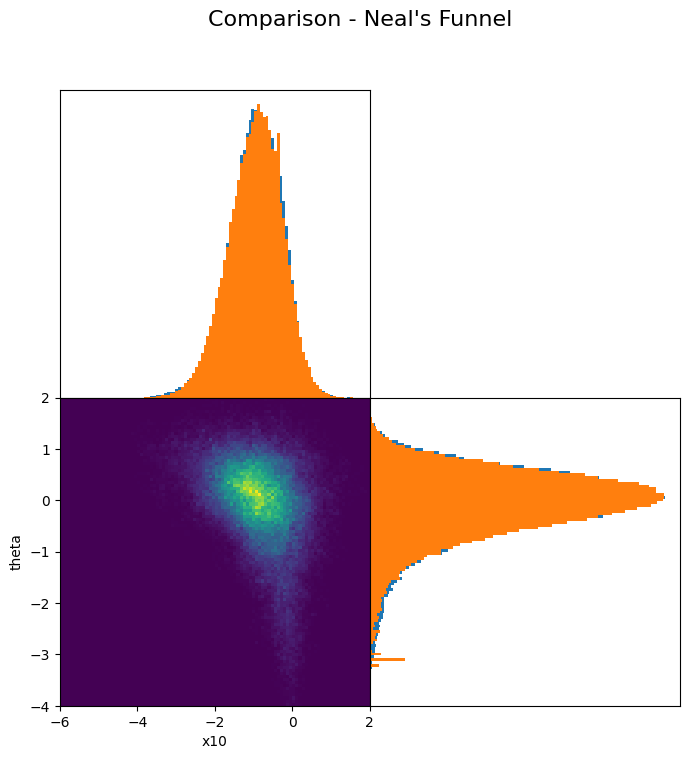

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Comparison - Neal's Funnel", fontsize=16)
fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4,2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");